  # Import the files & generate multi dataframes

In [2]:
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt
import os
import itertools

## Definition of functions 

In [3]:
# generate dataframes -- convert string table into the double table
import re,glob
def numericalpart(value): # will return the first number in the string 
    number=re.compile(r"(\d+)")
    parts=number.split(value)
    return int(parts[1])

def GenerateDflist(PATH):
    dflist=[]
    filelist_temp=sorted( glob.glob(PATH) , key = numericalpart )
    num=0
    for i in filelist_temp:
        time=num*0.04 # archive time is every 0.04 s
        temp_str=pd.read_csv(i,names=['Time'+str(time)])
        rows=len( temp_str['Time'+str(time)] )
        temp_str.index=range(1,rows+1)
        temp=temp_str['Time'+str(time)].str.split(r'\t',expand=True) # split into multi columns
        columns=['x','y','mat','mass','velx','vely','dispx','dispy','sxx','syy','sxy','pressure',
         'vonmises','exx','eyy','exy','pexx','peyy','pexy','equivstrain','strerg','work']
        temp.columns=columns # rename the columns
        temp=temp.apply(pd.to_numeric)
        dflist.append(temp)
        num=num+1
    return dflist

In [4]:
# the path should not contain number !!!!!!!!!!!!!!!!
path_rigid='Rigid/All/'
path_5Mpa='FiveMpa/All/' # this time step is a little bit different
path_20Mpa='TwentyMpa/All/'
path_80Mpa='EightyMpa/All/'
Figure_path='Figure/'

## Read into the data and convert 

In [5]:
filelist_rigid=GenerateDflist(path_rigid+'All_*.txt')

In [6]:
filelist_20Mpa=GenerateDflist(path_20Mpa+'All_*.txt')

In [7]:
filelist_5Mpa=GenerateDflist(path_5Mpa+'All_*.txt')

In [8]:
filelist_80Mpa=GenerateDflist(path_80Mpa+'All_*.txt')

# Plotting

## Definition of functions

In [9]:
############## Fit by polynominal ########################################### 
# INPUT: list x , list y
#        order: the order of polynominal
#        step: step of the fitted function
# OUTPUT: function 
#         xval, yval  (within the range of list x and list y)

def PolyFit(x,y,order,step):
    z1=np.polyfit(x,y,order)
    function=np.poly1d(z1)
    xval=np.arange(min(x),max(x),step)
    yval=np.polyval(z1,xval)
    return function,xval,yval
#############################################################################


In [10]:
############## Moving average ############################################### 
# INPUT: list x , list y
# OUTPUT:val_x, val_y  (within the range of list x and list y)
def moving_average(interval, window_size):
    ''' Coupute convoluted window for given size'''
    window = np.ones( int (window_size) ) /float( window_size)
    return np.convolve( interval, window,'same' )

#############################################################################

In [11]:
############## Scatter ###################################################### 
# INPUT: list x , list y
# OUTPUT:Figure
#############################################################################

## run up height against stiffness

315.0
3.8729833462074175
195.0


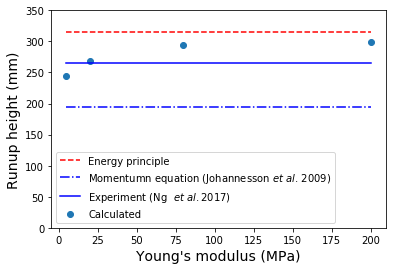

In [111]:
h=0.03 #unit m
vx= 2.1# m/s
g=9.8 # m/s^2
theta= 40.* np.pi/180
froude=vx/np.sqrt(g*h)

# energy approach
#h_f= (1+ vx**2/(g*h*np.cos(theta)))
h_f=h*10.5*1000
print (h_f)
print (froude)
# continuum approach
h_f2=6.5*0.03*1000
print (h_f2)
#simulation 
E=[5,20,80,200]
hf=[244,269,295,299]

plt.plot
plt.scatter(E,hf,label='Calculated')
plt.xlabel("Young's modulus (MPa)", fontsize=14)
plt.ylabel('Runup height (mm)', fontsize=14)

horiz_line_data = np.array([h_f for i in range(len(E))])
plt.plot(E, horiz_line_data, 'r--',label='Energy principle')

horiz_line_data = np.array([h_f2 for i in range(len(E))])
plt.plot(E, horiz_line_data, 'b-.',label='Momentumn equation (Johannesson $ et\ al$. 2009)')

horiz_line_data = np.array([265 for i in range(len(E))])
plt.plot(E, horiz_line_data, 'b-',label=r'Experiment (Ng $\  et \  al. 2017)$')

#plt.title('Runup height '
plt.ylim(0,350)
name='runupheight.png'
plt.legend()
plt.savefig(Figure_path+'/RunupHeight/'+name,dpi=300)
plt.show()

## Velocity distribution along depth

In [13]:
marker=itertools.cycle( ('^','+','o','s','p','x') )
linetype=itertools.cycle( [':','-','-.'] ) 

### Different position at the same time

In [14]:
debris,base,barrier=["mat==1","mat==2","mat==3"]
Timestep=np.arange(18,40,2)
position=["x>700 & x<702","x>800 & x<802", "x>900 & x<902",
          "x>1000& x<1002","x>1100 & x<1102","x<1200 & x>1197"]
for j in range(len(Timestep)):
    for i in range(0,len(position)-3):
        filtCondition=debris +'&'+position[i]
        filtered=filelist_rigid[Timestep[j]].query( filtCondition )
        function,x,y= PolyFit(filtered.velx,filtered.y,2,5)
        #print(function)
        lb=' x= '+ str( numericalpart(position[i]) ) + ' mm'
        plt.scatter(filtered.velx,filtered.y,label= lb, marker=next(marker))
        plt.plot(x,y,label='Fitted data'+lb,linestyle=next(linetype))
    plt.legend()
    #plt.xlim(1000,)
    plt.ylim(0,)
    plt.xlabel('velocity in flow direction (mm/s)', fontsize=14)
    plt.ylabel('flow height (mm)', fontsize=14)
    plt.title('Time='+str(Timestep[j]*0.04)+' s')
    name='Position x=[700,900] Time='+str(Timestep[j]*0.04)+'s.png'
    plt.savefig(Figure_path+'/VelxDistributionRigid/SameTime/'+name,dpi=300)
    #plt.show()
    plt.close()

In [15]:
for j in range(len(Timestep)):
    for i in range(3,len(position)):
        filtCondition=debris +'&'+position[i]
        filtered=filelist_rigid[Timestep[j]].query( filtCondition )
        function,x,y= PolyFit(filtered.velx,filtered.y,2,5)
        #print(function)
        lb=' x= '+ str( numericalpart(position[i]) ) + ' mm'
        plt.scatter(filtered.velx,filtered.y,label= lb, marker=next(marker))
        plt.plot(x,y,label='Fitted data'+lb,linestyle=next(linetype))
    plt.legend()
    plt.ylim(0,)
    plt.xlabel('velocity in flow direction (mm/s)', fontsize=14)
    plt.ylabel('flow height (mm)', fontsize=14)
    plt.title('Time='+str(Timestep[j]*0.04)+' s')
    name='Position x=[1000,1200] Time='+str(Timestep[j]*0.04)+'s.png'
    plt.savefig(Figure_path+'/VelxDistributionRigid/SameTime/'+name,dpi=300)
    #plt.show()
    plt.close()

### Smae position of different time 

In [16]:
linetype=itertools.cycle( [':','-','--','-.'] ) 
marker=itertools.cycle( ('^','+','o','s') )
Timestep=np.arange(20,28,2)
position=["x>700 & x<702","x>800 & x<802", "x>900 & x<902",
          "x>1000& x<1002","x>1100 & x<1102","x<1200 & x>1197"]
for i in range(0,len(position)-3):
    for j in range(len(Timestep)):
        filtCondition=debris +'&'+position[i]
        filtered=filelist_rigid[Timestep[j]].query( filtCondition )
        function,x,y= PolyFit(filtered.velx,filtered.y,2,5)
        #print(function)
        lb=' t= '+ str( Timestep[j]*0.04 ) + ' s'
        plt.scatter(filtered.velx,filtered.y,label= lb, marker=next(marker))
        plt.plot(x,y,label='Fitted data'+lb,linestyle=next(linetype))
    plt.legend()
    #plt.xlim(1000,)
    plt.ylim(0,)
    plt.xlabel('velocity in flow direction (mm/s)', fontsize=14)
    plt.ylabel('flow height (mm)', fontsize=14)
    plt.title('Position x= '+ str( numericalpart(position[i]) ) + ' mm')
    name='[700,900] '+ position[i] + 'Time='+str(Timestep[j]*0.04)+'s.png'
    plt.savefig(Figure_path+'/VelxDistributionRigid/SamePosition/'+name,dpi=300)
    #plt.show()
    plt.close()

In [17]:
for i in range(3,len(position)):
    for j in range(len(Timestep)):
        filtCondition=debris +'&'+position[i]
        filtered=filelist_rigid[Timestep[j]].query( filtCondition )
        function,x,y= PolyFit(filtered.velx,filtered.y,2,5)
        #print(function)
        lb=' t= '+ str( Timestep[j]*0.04 ) + ' s'
        plt.scatter(filtered.velx,filtered.y,label= lb, marker=next(marker))
        plt.plot(x,y,label='Fitted data'+lb,linestyle=next(linetype))
    plt.legend()
    #plt.xlim(1000,)
    plt.ylim(0,)
    plt.xlabel('velocity in flow direction (mm/s)', fontsize=14)
    plt.ylabel('flow height (mm)', fontsize=14)
    plt.title('Position x= '+ str( numericalpart(position[i]) ) + ' mm')
    name='Same Position x=[1000,1200]'+ position[i]+'Time='+str(Timestep[j]*0.04)+'s.png'
    plt.savefig(Figure_path+'/VelxDistributionRigid/SamePosition/'+name,dpi=300)
    #plt.show()
    plt.close()

## Impact pressure before the barrier

In [112]:
def Average(list1):
    if len(list1)==0:
        return 0
    else:
        return sum(list1)/len(list1)
        
def TimeHistory(dflist,filtCondition,index):
    F=[]
    Time=[]
    num=0
    for i in dflist:
        filtered= i.query( filtCondition )
        F.append( Average(filtered[index].tolist() ) )
        Time.append(num*0.04)
        num+=1
    return F,Time

In [69]:
linetype=itertools.cycle( [':','-','--','-.'] ) 
# debris,base,barrier=["mat==1","mat==2","mat==3"]
# position,value=["x>1196 & x<1197","velx > 0"]
# filtCondition_force =debris +'&'+position+'& '+ value

# velocity,t_velx=TimeSeries(filelist_80Mpa,filtCondition,'velx')
# F_estimate=[2.65*(x**2)/1000 for x in velocity] # rho * v^2
# F,t=TimeSeries(filelist_rigid,filtCondition_force,'vonmises')

# plt.plot(t,F,label='Impact pressure',linestyle=next(linetype))
# plt.plot(t_velx,F_estimate,label=r'$\rho  v^2 $',linestyle=next(linetype))
# #horiz_line_data = np.array([p_analytical for i in range(len(t))])
# print(velocity)
# #plt.plot(t, horiz_line_data, 'b-',label='Reference line')
# plt.legend(loc='upper right')
# plt.xlabel('Time (s)', fontsize=12)
# plt.ylabel('Impact pressure (Pa)', fontsize=12)
# plt.title(r'$\rho \  v^2 $ calculation')
# plt.savefig(Figure_path+'/velocity.png',dpi=300)
# plt.show()
# plt.close()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2594.8500000000004, 73.87569769230768, 6.243720123456792, 16.974177638888904, 2.835014574358968, 5.535731674008808, 18.84320345849803, 9.228589753036436, 18.53480608429116, -0.27882094339622665, -0.00592721481481404, 0.3832568535714301, 5.667000428082192, -0.09967172847681657, 3.815966163522016, 1.91783227672956, -0.9225280804953554, -0.816173083591331, -1.1917798489164086, -0.7729109995076914, -0.6518241318042813, 0.31783842857142935, 0.8868364969879511, -0.06729238722891398, 0.6615251674698789, 0.438923966867471, 0.21595229457831436, 1.0101452523952101, -1.1190480270270253, -0.9010273483035705, 2.6424573046647213, -0.8291198951149421, 2.2746592716763017, -0.10575802040229927, 0.44144111514285833, 1.699773239943343, 1.5816052691218125] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17843.103284625005, 14.462689580241873, 0.10330770859715714, 0.7635251722688736, 0.021298865237593567, 0.08120746169155456, 0.9409257389326

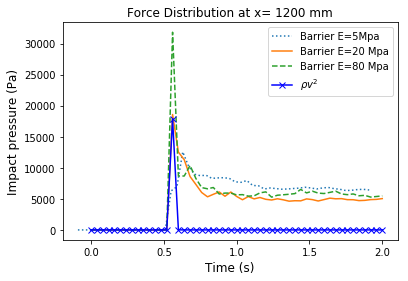

In [166]:
linetype=itertools.cycle( [':','-','--','-.'] ) 
debris,base,barrier,position=["mat==1","mat==2","mat==3","x>1198 & x<1200"]
filtCondition_force =debris +'&'+position

F_rigid,t=TimeHistory(filelist_rigid,filtCondition_force,'vonmises')
F_5Mpa,t2=TimeHistory(filelist_5Mpa,filtCondition_force,'vonmises')
F_20Mpa,t=TimeHistory(filelist_20Mpa,filtCondition_force,'vonmises')
F_80Mpa,t=TimeHistory(filelist_80Mpa,filtCondition_force,'vonmises')

velocity,t_velx=TimeSeries(filelist_rigid,filtCondition,'velx')
F_estimate=[2650*(x/1000)**2  for x in velocity] # rho * v^2
print (velocity,F_estimate)

#plt.plot(t,F_rigid,label='Rigid barrier',linestyle=next(linetype))
t2[:]=[x-1.09 for x in t2]
plt.plot(t2[25:],F_5Mpa[25:],label='Barrier E=5Mpa',linestyle=next(linetype))
plt.plot(t,F_20Mpa,label='Barrier E=20 Mpa',linestyle=next(linetype))
plt.plot(t,F_80Mpa,label='Barrier E=80 Mpa',linestyle=next(linetype))
plt.plot(t_velx,F_estimate,'xb-',label=r'$\rho  v^2 $')

p_analytical=2650*(2.5**2)

plt.legend(loc=r'upper right')
plt.xlabel(r'Time (s)', fontsize=12)
plt.ylabel(r'Impact pressure (Pa)', fontsize=12)
plt.title(r'Force Distribution at x= 1200 mm')
plt.savefig(Figure_path+'/Force x=1200.png',dpi=300)
plt.show()
plt.close()

## Earth pressure

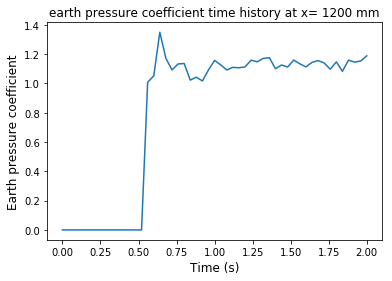

In [154]:
debris,base,barrier,position=["mat==1","mat==2","mat==3","x>1199& x<1200"]
filtCondition_force =debris +'&'+position
K=[]
Time=[]
num=0
for i in filelist_rigid:
    filted=i.query(filtCondition_force)
    K.append( Average(filted.sxx/filted.syy) )
    Time.append(num*0.04)
    num+=1
plt.plot(Time,K)
plt.xlabel(r'Time (s)', fontsize=12)
plt.ylabel(r'Earth pressure coefficient', fontsize=12)
plt.title(r'earth pressure coefficient time history at x= 1200 mm')
plt.savefig(Figure_path+'/earthpressure/rigid.png',dpi=300)
plt.show()

In [152]:
def TimeSeries_earthpresure(dflist):
    K=[]
    Time=[]
    num=0
    for i in dflist:
        filted=i.query(filtCondition_force)
        K.append( Average(filted.sxx/filted.syy) )
        Time.append(num*0.04)
        num+=1
    return K,Time

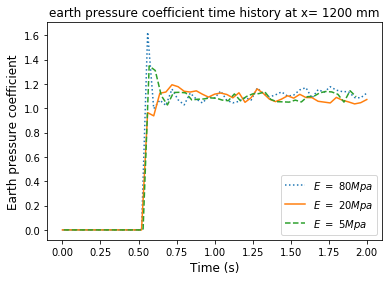

In [162]:
# time history of the earth pressure 
debris,base,barrier,position=["mat==1","mat==2","mat==3","x>1199& x<1200"]
filtCondition_force =debris +'&'+position

dfAll=[filelist_20Mpa,filelist_80Mpa,filelist_rigid]

K_80Mpa,t_80Mpa=TimeSeries_earthpresure(filelist_80Mpa)
plt.plot(t_80Mpa,K_80Mpa,label=r'$E \ =\ 80Mpa$',linestyle=next(linetype))

K_20Mpa,t_20Mpa=TimeSeries_earthpresure(filelist_20Mpa)
plt.plot(t_20Mpa,K_20Mpa,label=r'$E \ =\ 20Mpa$',linestyle=next(linetype))

K_5Mpa,t_5Mpa=TimeSeries_earthpresure(filelist_5Mpa)
t_5Mpa=[ x-1.07 for x in t_5Mpa]
plt.plot(t_5Mpa[27:],K_5Mpa[27:],label=r'$E \ =\ 5Mpa$',linestyle=next(linetype))

plt.xlabel(r'Time (s)', fontsize=12)
plt.ylabel(r'Earth pressure coefficient', fontsize=12)
plt.title(r'earth pressure coefficient time history at x= 1200 mm')
plt.legend()
plt.savefig(Figure_path+'/earthpressure/All.png',dpi=300)
plt.show()

In [175]:
# volume change and density change 
dfbeforeImpact=filelist_rigid[40]
dfbeforeImpact.head()

,x,y,mat,mass,velx,vely,dispx,dispy,sxx,syy,...,vonmises,exx,eyy,exy,pexx,peyy,pexy,equivstrain,strerg,work
1,584.328,2.100910,1,0.004141,861.678,238.9620,775.774,2.341220,-9275.04,-7063.37,...,2323.14,-8.47899,-485.66200,-131.912000,0,0,0,329.8970,0.000108,0
2,586.413,12.439200,1,0.004141,875.662,229.4710,777.761,12.552700,8646.06,7501.94,...,7477.46,-0.42413,-1.27383,-2.659310,0,0,0,1.7083,0.000053,0
3,586.938,10.888100,1,0.004141,881.105,17.9937,789.265,10.794800,-12786.20,-17906.80,...,4489.64,4.92590,-221.52300,-0.764055,0,0,0,149.3510,0.000042,0
4,576.561,1.332240,1,0.004141,1195.200,-189.4400,773.721,0.697100,4842.64,4619.09,...,4382.67,-1.79467,-3.08838,57.928100,0,0,0,33.4927,0.000051,0
5,561.633,0.997725,1,0.004141,196.208,-221.8430,749.037,0.661775,4241.20,6378.65,...,3192.02,1876.47000,17420.40000,28719.900000,0,0,0,19921.3000,0.000055,0


In [176]:
dfbeforeImpact['Dvolume']=dfbeforeImpact['exx']+dfbeforeImpact['eyy']
dfbeforeImpact['Density']=dfbeforeImpact['mass']/dfbeforeImpact['Dvolume']
dfbeforeImpact.head()

,x,y,mat,mass,velx,vely,dispx,dispy,sxx,syy,...,eyy,exy,pexx,peyy,pexy,equivstrain,strerg,work,Dvolume,Density
1,584.328,2.100910,1,0.004141,861.678,238.9620,775.774,2.341220,-9275.04,-7063.37,...,-485.66200,-131.912000,0,0,0,329.8970,0.000108,0,-494.14099,-8.379451e-06
2,586.413,12.439200,1,0.004141,875.662,229.4710,777.761,12.552700,8646.06,7501.94,...,-1.27383,-2.659310,0,0,0,1.7083,0.000053,0,-1.69796,-2.438591e-03
3,586.938,10.888100,1,0.004141,881.105,17.9937,789.265,10.794800,-12786.20,-17906.80,...,-221.52300,-0.764055,0,0,0,149.3510,0.000042,0,-216.59710,-1.911674e-05
4,576.561,1.332240,1,0.004141,1195.200,-189.4400,773.721,0.697100,4842.64,4619.09,...,-3.08838,57.928100,0,0,0,33.4927,0.000051,0,-4.88305,-8.479598e-04
5,561.633,0.997725,1,0.004141,196.208,-221.8430,749.037,0.661775,4241.20,6378.65,...,17420.40000,28719.900000,0,0,0,19921.3000,0.000055,0,19296.87000,2.145752e-07
